In [117]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/cover_type_updated_soil_features.csv')
df.head()

,Unnamed: 0,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type39,Soil_Type40,Cover_Type,Inceptisols,Mollisols,Spodosols,Alfisols,Entisols,Unknown,Histosols
0,0,2596,51,3,258,0,510,221,232,148,...,0,0,5,1,0,0,0,0,0,0
1,1,2590,56,2,212,-6,390,220,235,151,...,0,0,5,1,0,0,0,0,0,0
2,2,2804,139,9,268,65,3180,234,238,135,...,0,0,2,0,0,0,0,1,0,0
3,3,2785,155,18,242,118,3090,238,238,122,...,0,0,2,1,0,0,0,0,0,0
4,4,2595,45,2,153,-1,391,220,234,150,...,0,0,5,1,0,0,0,0,0,0


In [118]:
df.drop('Unnamed: 0',axis = 1,inplace = True)

In [119]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [120]:
df['Horizontal_Distance_To_Fire_Points'].describe()

count    581012.000000
mean       1980.291226
std        1324.195210
min           0.000000
25%        1024.000000
50%        1710.000000
75%        2550.000000
max        7173.000000
Name: Horizontal_Distance_To_Fire_Points, dtype: float64

In [121]:
import numpy as np

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff695187490>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff695185180>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff695186710>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff695186470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff695185510>],
 'means': []}

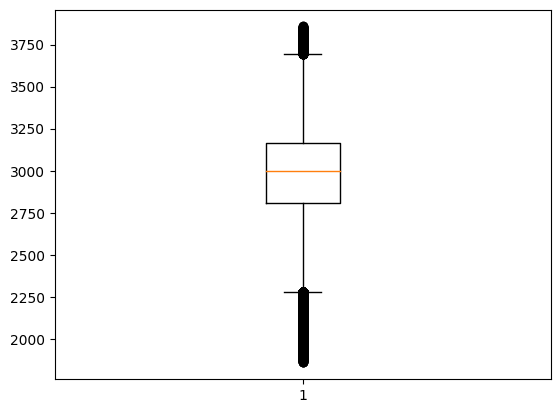

In [122]:
plt.boxplot(df['Elevation'])

In [123]:
df['Elevation'].describe()

count    581012.000000
mean       2959.365301
std         279.984734
min        1859.000000
25%        2809.000000
50%        2996.000000
75%        3163.000000
max        3858.000000
Name: Elevation, dtype: float64

<Axes: xlabel='Elevation', ylabel='Density'>

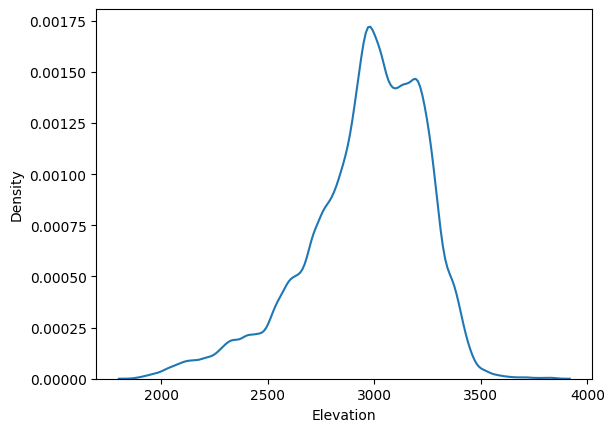

In [124]:
import seaborn as sns
sns.kdeplot(df['Elevation'])

<Axes: >

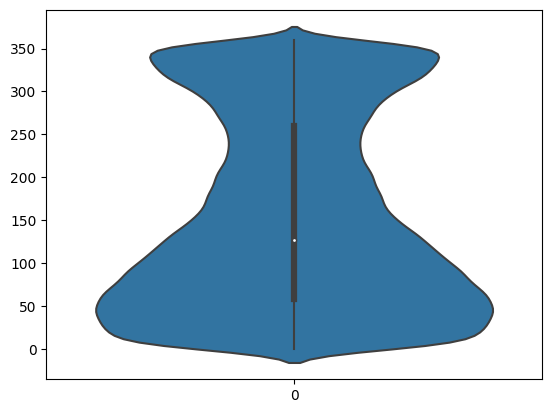

In [125]:
sns.violinplot(df['Aspect'])

<Axes: xlabel='Aspect', ylabel='Density'>

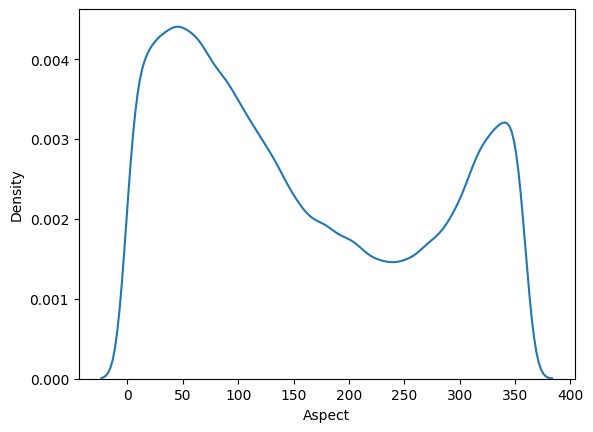

In [126]:
import seaborn as sns
sns.kdeplot(df['Aspect'])

In [127]:
df['Aspect'].shape

(581012,)

In [128]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(df['Aspect'].values.reshape(-1, 1))

# Generate a unimodal distribution using the means and standard deviations of the component distributions
means, stds = gmm.means_, np.sqrt(gmm.covariances_).reshape(-1)
unimodal_data = norm.rvs(loc=means.mean(), scale=stds.mean(), size=581012)

(array([1.35000e+02, 2.58200e+03, 2.22600e+04, 9.30350e+04, 1.85072e+05,
        1.77035e+05, 8.13200e+04, 1.76230e+04, 1.84600e+03, 1.04000e+02]),
 array([-52.39304549,  -4.90065893,  42.59172764,  90.08411421,
        137.57650077, 185.06888734, 232.5612739 , 280.05366047,
        327.54604704, 375.0384336 , 422.53082017]),
 <BarContainer object of 10 artists>)

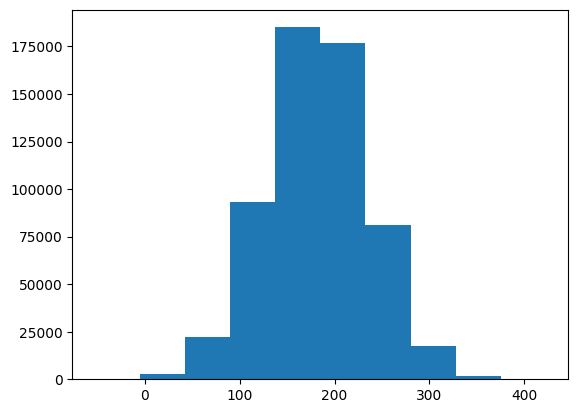

In [129]:
plt.hist(unimodal_data)

In [130]:
unimodal_data.shape

(581012,)

In [131]:
df['Aspect_unimodal'] = unimodal_data

In [132]:
df['Aspect_unimodal']

0         196.378835
1         114.414711
2         217.939118
3         185.402547
4         189.197856
             ...    
581007    128.045350
581008    165.199160
581009    208.161504
581010    205.686382
581011    237.318678
Name: Aspect_unimodal, Length: 581012, dtype: float64

In [133]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(df,column_list):
  for i in column_list:
    tf = StandardScaler()
    df[i] = tf.fit_transform(df[i].values.reshape(-1,1))
  return df

In [134]:
df = standard_scaling(df,['Aspect_unimodal'])

(array([1.35000e+02, 2.58200e+03, 2.22600e+04, 9.30350e+04, 1.85072e+05,
        1.77035e+05, 8.13200e+04, 1.76230e+04, 1.84600e+03, 1.04000e+02]),
 array([-4.37417576, -3.48839611, -2.60261646, -1.7168368 , -0.83105715,
         0.0547225 ,  0.94050215,  1.8262818 ,  2.71206145,  3.59784111,
         4.48362076]),
 <BarContainer object of 10 artists>)

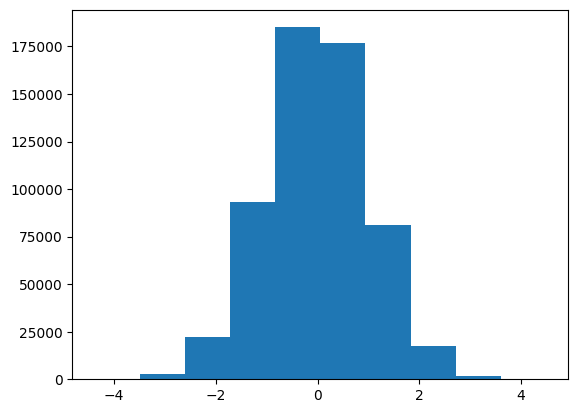

In [135]:
plt.hist(df['Aspect_unimodal'])

In [136]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# from sklearn.mixture import GaussianMixture

# # Generate some bimodal data
# np.random.seed(42)
# data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(5, 2, 1000)])

# # Fit a mixture model to the data
# gmm = GaussianMixture(n_components=2, random_state=42)
# gmm.fit(data.reshape(-1, 1))

# # Generate a unimodal distribution using the means and standard deviations of the component distributions
# means, stds = gmm.means_, np.sqrt(gmm.covariances_).reshape(-1)
# unimodal_data = norm.rvs(loc=means.mean(), scale=stds.mean(), size=1000)

# # Plot the original data, the mixture model, and the unimodal distribution
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].hist(data, bins=50)
# axs[0].set_title("Original Data")
# axs[1].hist(data, bins=50, alpha=0.5)
# x = np.linspace(-10, 20, 1000)
# axs[1].plot(x, gmm.predict_proba(x.reshape(-1, 1))[:, 0]*1000, label="Component 1")
# axs[1].plot(x, gmm.predict_proba(x.reshape(-1, 1))[:, 1]*1000, label="Component 2")
# axs[1].set_title("Mixture Model")
# axs[1].legend()
# axs[2].hist(unimodal_data, bins=50)
# axs[2].set_title("Unimodal Data")
# plt.show()

<Axes: xlabel='Slope', ylabel='Density'>

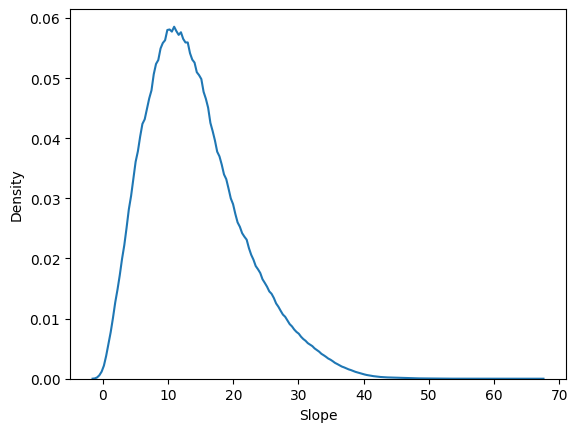

In [137]:
import seaborn as sns
sns.kdeplot(df['Slope'])

<Axes: >

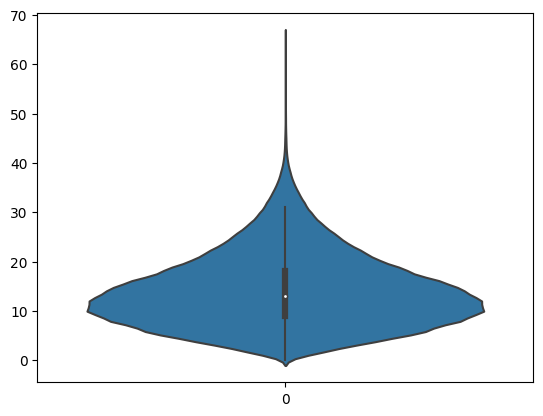

In [138]:
sns.violinplot(df['Slope'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Slope', ylabel='Density'>

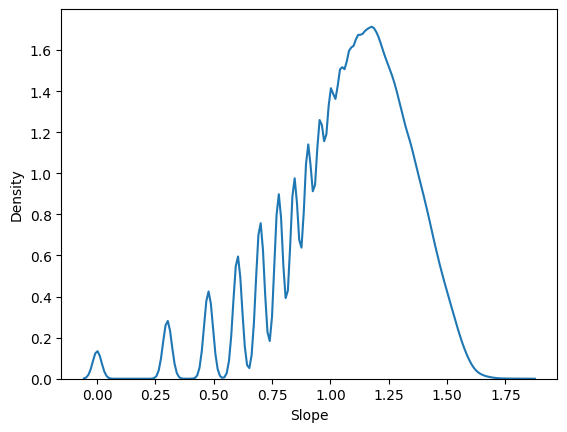

In [139]:
xx = np.log10(df['Slope'])
sns.kdeplot(xx)

<Axes: xlabel='Horizontal_Distance_To_Hydrology', ylabel='Density'>

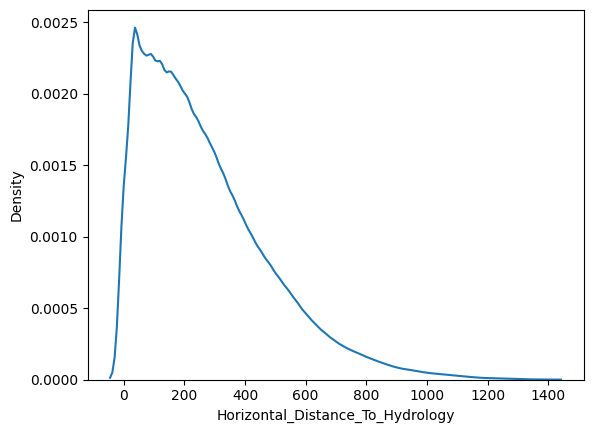

In [140]:
import seaborn as sns
sns.kdeplot(df['Horizontal_Distance_To_Hydrology'])

<Axes: xlabel='Vertical_Distance_To_Hydrology', ylabel='Density'>

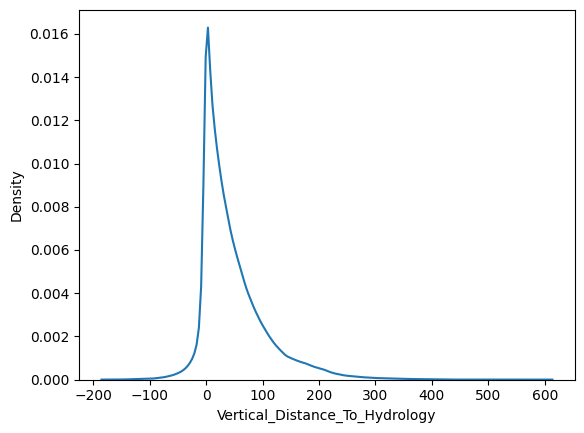

In [141]:
import seaborn as sns
sns.kdeplot(df['Vertical_Distance_To_Hydrology'])

In [142]:
df = standard_scaling(df,['Vertical_Distance_To_Hydrology'])

<Axes: xlabel='Elevation', ylabel='Density'>

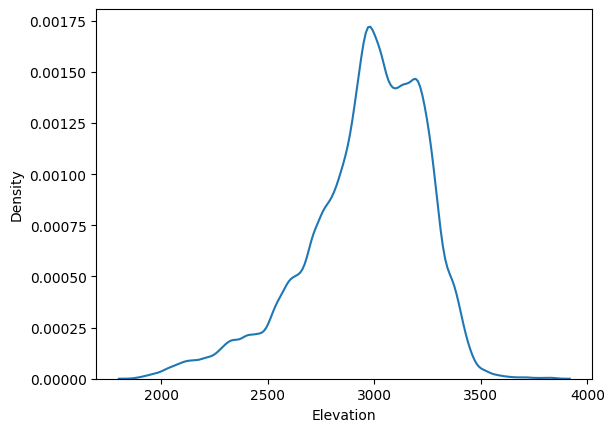

In [143]:
import seaborn as sns
sns.kdeplot(df['Elevation'])

In [144]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type40,Cover_Type,Inceptisols,Mollisols,Spodosols,Alfisols,Entisols,Unknown,Histosols,Aspect_unimodal
0,2596,51,3,258,-0.796273,510,221,232,148,6279,...,0,5,1,0,0,0,0,0,0,0.265664
1,2590,56,2,212,-0.899197,390,220,235,151,6225,...,0,5,1,0,0,0,0,0,0,-1.263047
2,2804,139,9,268,0.318742,3180,234,238,135,6121,...,0,2,0,0,0,0,1,0,0,0.667785
3,2785,155,18,242,1.227908,3090,238,238,122,6211,...,0,2,1,0,0,0,0,0,0,0.060946
4,2595,45,2,153,-0.813427,391,220,234,150,6172,...,0,5,1,0,0,0,0,0,0,0.131732


<Axes: xlabel='Horizontal_Distance_To_Hydrology', ylabel='Density'>

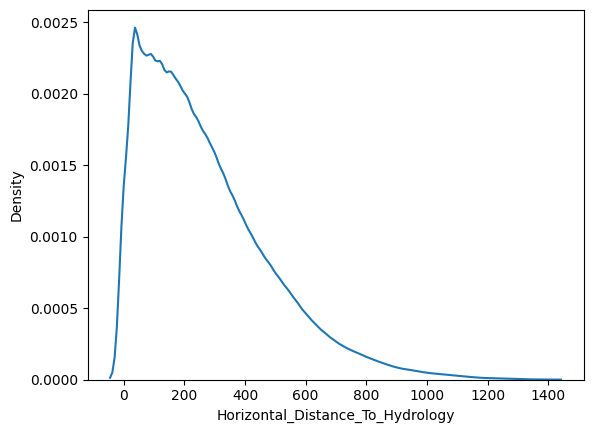

In [145]:
sns.kdeplot((df['Horizontal_Distance_To_Hydrology']))

In [146]:
# df['Horizontal_Distance_To_Roadways'] = df['Horizontal_Distance_To_Roadways']+0.1
# df['Horizontal_Distance_To_Fire_Points'] = df['Horizontal_Distance_To_Fire_Points']+0.1

In [147]:
for i in range(0,len(df['Horizontal_Distance_To_Roadways'])):
  if df['Horizontal_Distance_To_Roadways'][i] == 0:
    df['Horizontal_Distance_To_Roadways'][i] = 0.1

<ipython-input-147-41d369b540d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizontal_Distance_To_Roadways'][i] = 0.1


In [148]:
for i in range(0,len(df['Horizontal_Distance_To_Fire_Points'])):
  if df['Horizontal_Distance_To_Fire_Points'][i] == 0.000000:
    df['Horizontal_Distance_To_Fire_Points'][i] = 0.1

<ipython-input-148-9e6d83ef634a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizontal_Distance_To_Fire_Points'][i] = 0.1


In [149]:
df['Horizontal_Distance_To_Fire_Points'].describe()

count    581012.000000
mean       1980.291235
std        1324.195197
min           0.100000
25%        1024.000000
50%        1710.000000
75%        2550.000000
max        7173.000000
Name: Horizontal_Distance_To_Fire_Points, dtype: float64

In [150]:
def log_transform(df,feature_list):
  for i in feature_list:
    df[i] = np.log10(df[i])
  return df

In [151]:
df = log_transform(df,['Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points'])

<Axes: xlabel='Horizontal_Distance_To_Roadways', ylabel='Density'>

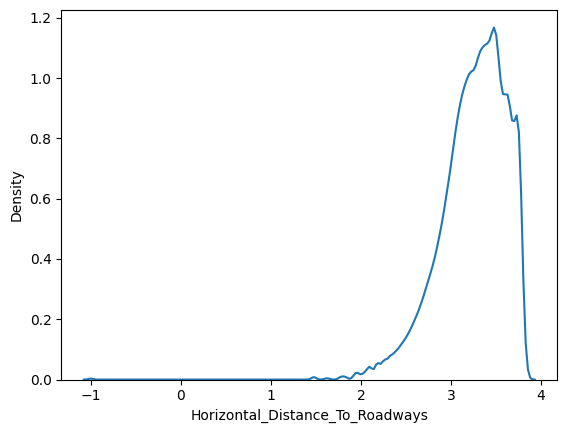

In [152]:
sns.kdeplot((df['Horizontal_Distance_To_Roadways']))

In [153]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(dfa,column_list):
  for i in column_list:
    tf = StandardScaler()
    dfa[i] = tf.fit_transform(dfa[i].values.reshape(-1,1))
  return dfa

In [154]:
df = standard_scaling(df,['Horizontal_Distance_To_Hydrology','Elevation','Slope','Vertical_Distance_To_Hydrology','Hillshade_9am','Hillshade_Noon','Hillshade_3pm'])

In [155]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type40,Cover_Type,Inceptisols,Mollisols,Spodosols,Alfisols,Entisols,Unknown,Histosols,Aspect_unimodal
0,-1.297805,51,-1.482820,-0.053767,-0.796273,2.707570,0.330743,0.439143,0.142960,3.797890,...,0,5,1,0,0,0,0,0,0,0.265664
1,-1.319235,56,-1.616363,-0.270188,-0.899197,2.591065,0.293388,0.590899,0.221342,3.794139,...,0,5,1,0,0,0,0,0,0,-1.263047
2,-0.554907,139,-0.681563,-0.006719,0.318742,3.502427,0.816364,0.742654,-0.196691,3.786822,...,0,2,0,0,0,0,1,0,0,0.667785
3,-0.622768,155,0.520322,-0.129044,1.227908,3.489958,0.965786,0.742654,-0.536343,3.793162,...,0,2,1,0,0,0,0,0,0,0.060946
4,-1.301377,45,-1.616363,-0.547771,-0.813427,2.592177,0.293388,0.540313,0.195215,3.790426,...,0,5,1,0,0,0,0,0,0,0.131732


In [156]:
df = standard_scaling(df,['Aspect'])

In [157]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

**Baseline model**

In [158]:
from sklearn.model_selection import train_test_split
def split_data(df,y,test_size):
  xtrain,x_test,y_train,y_test = train_test_split(df.drop(y,axis = 1),df[y],test_size = test_size)
  return xtrain,x_test,y_train,y_test

In [182]:
base_features = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type']]

In [44]:
x_train,x_test,y_train,y_test = split_data(df,'Cover_Type',0.3)

building based on base features

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report

In [127]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(multi_class='multinomial')
mod.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [131]:
c = mod.predict(x_test)
print(classification_report(y_test, c))

              precision    recall  f1-score   support

           1       0.71      0.69      0.70     63717
           2       0.75      0.80      0.77     84934
           3       0.67      0.80      0.73     10620
           4       0.54      0.35      0.43       825
           5       0.45      0.04      0.08      2842
           6       0.49      0.26      0.34      5230
           7       0.73      0.57      0.64      6136

    accuracy                           0.72    174304
   macro avg       0.62      0.50      0.53    174304
weighted avg       0.71      0.72      0.71    174304



Feature importance

In [148]:
df.shape

(581012, 64)

In [89]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [90]:
all_features = df.drop('Aspect',axis = 1)
x_train,x_test,y_train,y_test = split_data(all_features,'Cover_Type',0.3)

In [91]:

tf = RFE(RandomForestClassifier(), n_features_to_select=30, verbose=1)
Xt = tf.fit_transform(x_train,y_train)
print("Shape =", Xt.shape)

Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 fe

In [92]:
tf.get_feature_names_out()

array(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type2', 'Soil_Type4', 'Soil_Type10', 'Soil_Type12',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Inceptisols',
       'Mollisols', 'Spodosols', 'Alfisols', 'Entisols',
       'Aspect_unimodal'], dtype=object)

In [188]:
top_30_features = df[['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type2', 'Soil_Type4', 'Soil_Type10', 'Soil_Type12',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Inceptisols',
       'Mollisols', 'Spodosols', 'Alfisols', 'Entisols',
       'Aspect_unimodal','Cover_Type']]

In [189]:
x_train,x_test,y_train,y_test = split_data(top_30_features,'Cover_Type',0.3)

In [190]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size = 0.2)

**PCA**

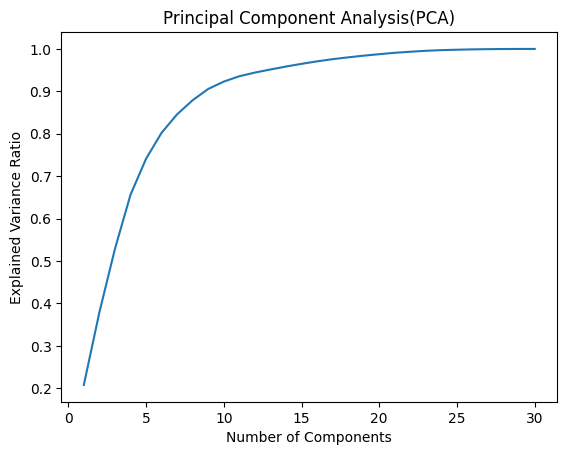

In [202]:
pca = PCA(n_components=30)
pca.fit(top_30_features)

import matplotlib.pyplot as plt
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.title("Principal Component Analysis(PCA)")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [203]:
# Get the explained variance ratio of each principal component
explained_var_ratio = pca.explained_variance_ratio_

# Create a dictionary with column names as keys and explained variance ratios as values
var_dict = dict(zip(x_train.columns, explained_var_ratio))

# Sort the dictionary in descending order of explained variance ratios
sorted_var_dict = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1], reverse=True)}

# Print the sorted dictionary
print(sorted_var_dict)

{'Elevation': 0.20785415218433764, 'Slope': 0.17105093508826494, 'Horizontal_Distance_To_Hydrology': 0.14948648476520282, 'Vertical_Distance_To_Hydrology': 0.1275176471926053, 'Horizontal_Distance_To_Roadways': 0.08496568616562634, 'Hillshade_9am': 0.061351966066308064, 'Hillshade_Noon': 0.043678220954140735, 'Hillshade_3pm': 0.033169472794293886, 'Horizontal_Distance_To_Fire_Points': 0.02656314925686531, 'Wilderness_Area1': 0.01732040380556921, 'Wilderness_Area2': 0.01266146080485029, 'Wilderness_Area3': 0.008598518906817152, 'Wilderness_Area4': 0.007248280910079362, 'Soil_Type2': 0.006984429359090582, 'Soil_Type4': 0.006365313535029594, 'Soil_Type10': 0.005881231109133694, 'Soil_Type12': 0.005140331409103625, 'Soil_Type22': 0.004296041794762224, 'Soil_Type23': 0.0039830891577728195, 'Soil_Type24': 0.0034860213305106576, 'Soil_Type29': 0.003281427832681755, 'Soil_Type32': 0.0025089599457898243, 'Soil_Type33': 0.0022077418665560305, 'Soil_Type38': 0.0015383898594843474, 'Inceptisols': 

In [204]:
explained_var_ratio

array([2.07854152e-01, 1.71050935e-01, 1.49486485e-01, 1.27517647e-01,
       8.49656862e-02, 6.13519661e-02, 4.36782210e-02, 3.31694728e-02,
       2.65631493e-02, 1.73204038e-02, 1.26614608e-02, 8.59851891e-03,
       7.24828091e-03, 6.98442936e-03, 6.36531354e-03, 5.88123111e-03,
       5.14033141e-03, 4.29604179e-03, 3.98308916e-03, 3.48602133e-03,
       3.28142783e-03, 2.50895995e-03, 2.20774187e-03, 1.53838986e-03,
       9.82157977e-04, 8.12520082e-04, 5.39350224e-04, 2.83709007e-04,
       1.58312642e-04, 8.45939743e-05])

In [206]:
c = [2.07854152e-01, 1.71050935e-01, 1.49486485e-01, 1.27517647e-01,
       8.49656862e-02, 6.13519661e-02, 4.36782210e-02, 3.31694728e-02,
       2.65631493e-02, 1.73204038e-02, 1.26614608e-02, 8.59851891e-03,
       7.24828091e-03, 6.98442936e-03, 6.36531354e-03, 5.88123111e-03,
       5.14033141e-03, 4.29604179e-03, 3.98308916e-03, 3.48602133e-03,
       3.28142783e-03, 2.50895995e-03, 2.20774187e-03, 1.53838986e-03,
       9.82157977e-04, 8.12520082e-04, 5.39350224e-04, 2.83709007e-04,
       1.58312642e-04, 8.45939743e-05]

In [207]:
sum  = 0
for i in c:
  sum += i
sum

0.9999999999362998

Smote

In [191]:
from imblearn.over_sampling import SMOTE

In [192]:
oversample = SMOTE()
X_train_smote, Y_train_smote = oversample.fit_resample(x_train, y_train)

In [193]:
Y_train_smote.value_counts()

1    158206
2    158206
3    158206
6    158206
7    158206
5    158206
4    158206
Name: Cover_Type, dtype: int64

In [194]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_cv = le.fit_transform(y_cv)
y_test = le.fit_transform(y_test)
Y_train_smote = le.fit_transform(Y_train_smote)

Gridsearch

In [54]:
param = { 
    'n_estimators': [100,200,300,400,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,25,50],
    'criterion' :['gini', 'entropy']
}

In [57]:
# grid = GridSearchCV(RandomForestClassifier(), param_grid = param_grid,cv = 5, verbose = 10,n_jobs=-1) 

In [60]:
#random = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param, cv=3,verbose=1, random_state=42,n_jobs=-1, return_train_score=True)

In [ ]:
# random.fit(X_train_smote,Y_train_smote)

In [ ]:
# best_model = random.best_estimator_

In [ ]:
# rand_predictions = best_model.predict(x_test) 

In [ ]:
# print(classification_report(x_test, rand_predictions)) 

In [ ]:
# from xgboost import XGBClassifier

In [ ]:
# estimator = XGBClassifier(
#     objective= 'binary:logistic',
#     nthread=4,
#     seed=42
# )

In [ ]:
# parameters = {
#     'max_depth': range(2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

In [ ]:
# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     scoring = 'f1_macro',
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )

In [ ]:
# grid_search.fit(X_train_smote,Y_train_smote)

In [ ]:
# best_model_xg = grid_search.best_estimator_

In [ ]:
# grid_predictions_xg = best_model_xg.predict(x_test) 

In [ ]:
# print(classification_report(y_test, grid_predictions_xg))

In [ ]:
# grid.best_params_

In [ ]:
# grid_search.best_params_

**Hyperparameter tuning using for loop**

depth 3 is finished
depth 5 is finished
depth 10 is finished
depth 20 is finished
depth 50 is finished
depth 100 is finished
f1 value score for depth =3 is 0.4279617263839251
f1 value score for depth =5 is 0.5033065618687179
f1 value score for depth =10 is 0.6433185934024326
f1 value score for depth =20 is 0.8587482005283265
f1 value score for depth =50 is 0.9114580639236456
f1 value score for depth =100 is 0.9110960717266998
best max depth is 50
f1 score on train data 1.0
f1 score on cv data 0.9141741165460588
f1 score on test data 0.9106655796750214


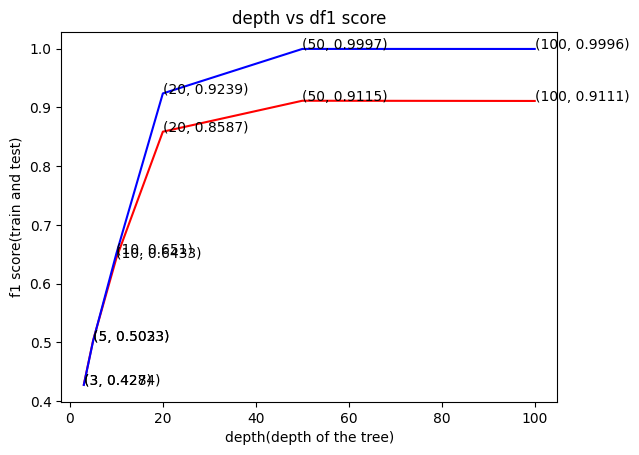

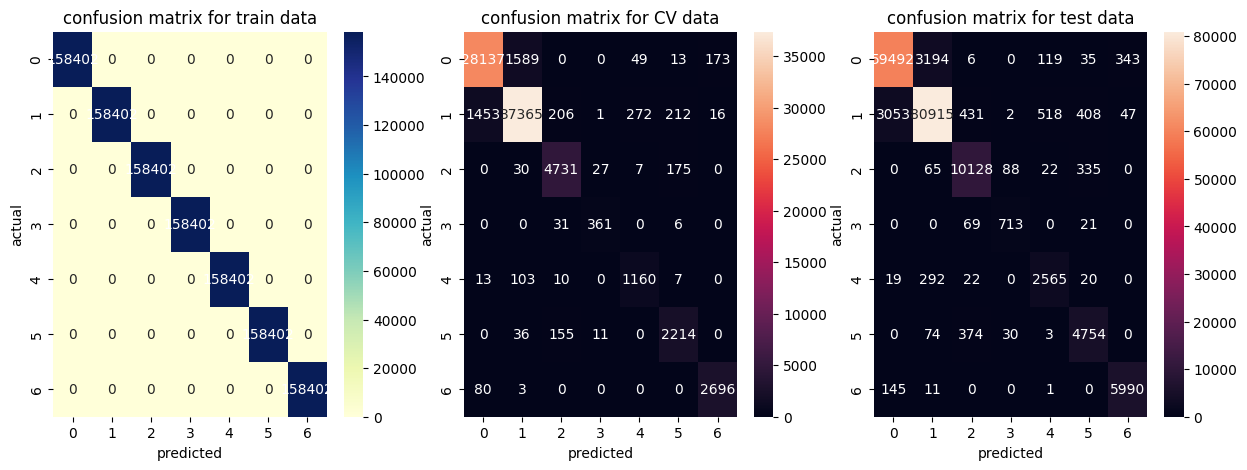

In [49]:
from sklearn.metrics import f1_score
depth = [3,5,10,20,50,100]
cv_f1_score = []
train_f1_score = []
for i in depth:
  model = RandomForestClassifier(max_depth = i,n_jobs = -1,n_estimators = 10)
  model.fit(X_train_smote, Y_train_smote)
  CV = CalibratedClassifierCV(model,method = 'sigmoid')
  CV.fit(X_train_smote, Y_train_smote)
  predicted = CV.predict(x_cv)
  train_predicted = CV.predict(x_train)
  cv_f1_score.append(f1_score(y_cv,predicted,average = 'macro'))
  train_f1_score.append(f1_score(y_train,train_predicted,average = 'macro'))
  print('depth {0} is finished'.format(i))
for i in range(0,len(cv_f1_score)):
  print('f1 value score for depth =' + str(depth[i]) + ' is ' + str(cv_f1_score[i]))
plt.plot(depth,cv_f1_score,c='r')
plt.plot(depth,train_f1_score,c='b')
plt.xlabel('depth(depth of the tree)')
plt.ylabel('f1 score(train and test)')
plt.title('depth vs df1 score')
for i,score in enumerate(cv_f1_score):
  plt.annotate((depth[i],np.round(score,4)),(depth[i],np.round(cv_f1_score[i],4)))
for i,score1 in enumerate(train_f1_score):
  plt.annotate((depth[i],np.round(score1,4)),(depth[i],np.round(train_f1_score[i],4)))
index = cv_f1_score.index(max(cv_f1_score))
best_dpt = depth[index]
print('best max depth is ' + str(best_dpt))
model = RandomForestClassifier(max_depth = best_dpt,n_jobs = -1)
model.fit(X_train_smote, Y_train_smote)
predict_train = model.predict(x_train)
print('f1 score on train data ' + str(f1_score(y_train,predict_train,average = 'macro')))
train_mat = confusion_matrix(y_train,predict_train)
predict_cv = model.predict(x_cv)
print('f1 score on cv data ' + str(f1_score(y_cv,predict_cv,average = 'macro')))
cv_mat = confusion_matrix(y_cv,predict_cv)
predict_test = model.predict(x_test)
print('f1 score on test data ' + str(f1_score(y_test,predict_test,average = 'macro')))
test_mat = confusion_matrix(y_test,predict_test)
fig,ax = plt.subplots(1,3,figsize = (15,5))
sns.heatmap(ax = ax[0],data = train_mat,annot=True,fmt='g',cmap="YlGnBu")
ax[0].set_xlabel('predicted')
ax[0].set_ylabel('actual')
ax[0].title.set_text('confusion matrix for train data')
sns.heatmap(ax = ax[1],data = cv_mat,annot=True,fmt='g')
ax[1].set_xlabel('predicted')
ax[1].set_ylabel('actual')
ax[1].title.set_text('confusion matrix for CV data')
sns.heatmap(ax = ax[2],data = test_mat,annot=True,fmt='g')
ax[2].set_xlabel('predicted')
ax[2].set_ylabel('actual')
ax[2].title.set_text('confusion matrix for test data')

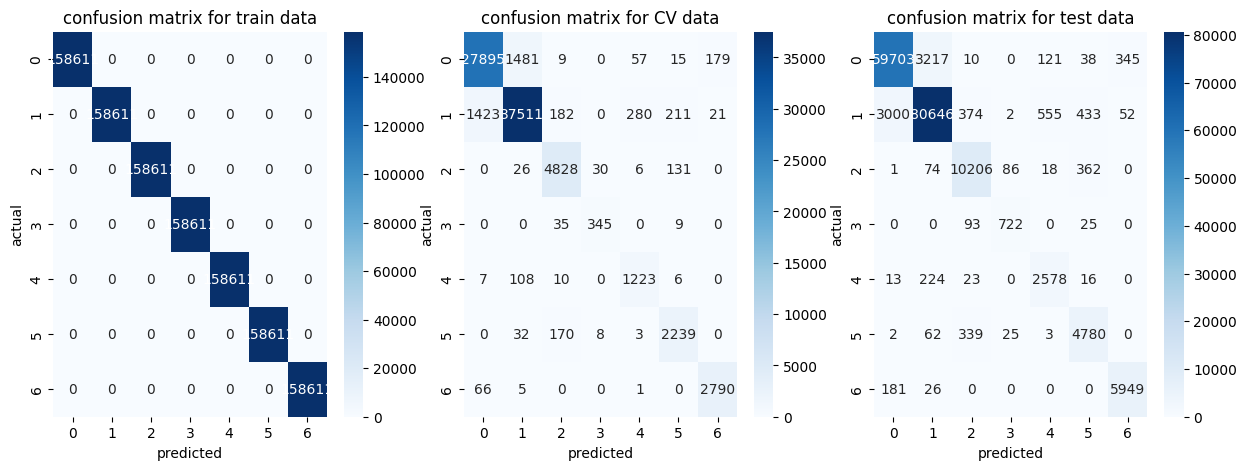

In [62]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
sns.heatmap(ax = ax[0],data = train_mat,annot=True,fmt='g',cmap="Blues")
ax[0].set_xlabel('predicted')
ax[0].set_ylabel('actual')
ax[0].title.set_text('confusion matrix for train data')
sns.heatmap(ax = ax[1],data = cv_mat,annot=True,fmt='g',cmap="Blues")
ax[1].set_xlabel('predicted')
ax[1].set_ylabel('actual')
ax[1].title.set_text('confusion matrix for CV data')
sns.heatmap(ax = ax[2],data = test_mat,annot=True,fmt='g',cmap="Blues")
ax[2].set_xlabel('predicted')
ax[2].set_ylabel('actual')
ax[2].title.set_text('confusion matrix for test data')

Estimator 10 is finished
Estimator 20 is finished
Estimator 50 is finished
Estimator 100 is finished
f1 value score n_estimators =10 is 0.9097165308172535
f1 value score n_estimators =20 is 0.9128096833611219
f1 value score n_estimators =50 is 0.913956263396549
f1 value score n_estimators =100 is 0.9148862965369429
best estimator is 100
f1 score on train data 1.0
f1 score on cv data 0.915988794462946
f1 score on test data 0.9122481004904831


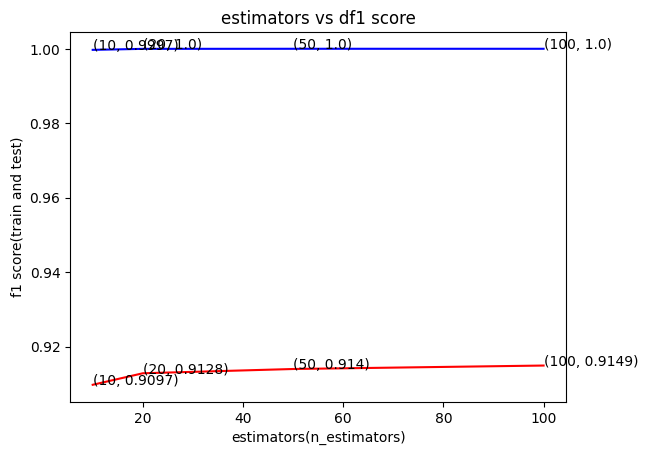

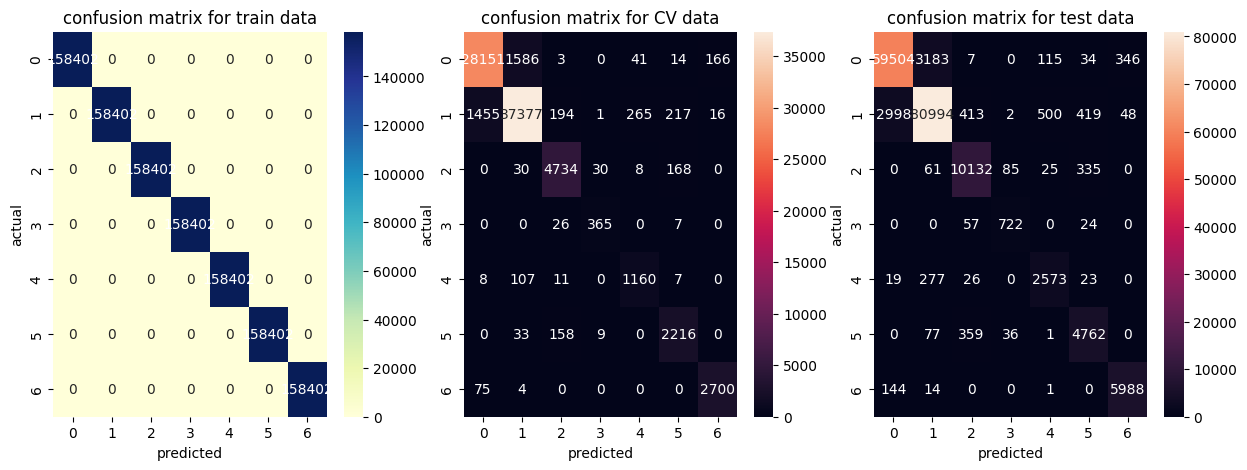

In [50]:
from sklearn.metrics import f1_score
estimators = [10,20,50,100]
cv_f1_score = []
train_f1_score = []
for i in estimators:
  model = RandomForestClassifier(n_estimators = i,max_depth = 50,n_jobs = -1)
  model.fit(X_train_smote, Y_train_smote)
  CV = CalibratedClassifierCV(model,method = 'sigmoid')
  CV.fit(X_train_smote, Y_train_smote)
  predicted = CV.predict(x_cv)
  train_predicted = CV.predict(x_train)
  cv_f1_score.append(f1_score(y_cv,predicted,average = 'macro'))
  train_f1_score.append(f1_score(y_train,train_predicted,average = 'macro'))
  print('Estimator {0} is finished'.format(i))
for i in range(0,len(cv_f1_score)):
  print('f1 value score n_estimators =' + str(estimators[i]) + ' is ' + str(cv_f1_score[i]))
plt.plot(estimators,cv_f1_score,c='r')
plt.plot(estimators,train_f1_score,c='b')
plt.xlabel('estimators(n_estimators)')
plt.ylabel('f1 score(train and test)')
plt.title('estimators vs df1 score')
for i,score in enumerate(cv_f1_score):
  plt.annotate((estimators[i],np.round(score,4)),(estimators[i],np.round(cv_f1_score[i],4)))
for i,score1 in enumerate(train_f1_score):
  plt.annotate((estimators[i],np.round(score1,4)),(estimators[i],np.round(train_f1_score[i],4)))
index = cv_f1_score.index(max(cv_f1_score))
best_est = estimators[index]
print('best estimator is ' + str(best_est))
model = RandomForestClassifier(n_estimators = best_est,max_depth = 50,n_jobs = -1)
model.fit(X_train_smote, Y_train_smote)
predict_train = model.predict(X_train_smote)
print('f1 score on train data ' + str(f1_score(Y_train_smote,predict_train,average = 'macro')))
train_mat = confusion_matrix(Y_train_smote,predict_train)
predict_cv = model.predict(x_cv)
print('f1 score on cv data ' + str(f1_score(y_cv,predict_cv,average = 'macro')))
cv_mat = confusion_matrix(y_cv,predict_cv)
predict_test = model.predict(x_test)
print('f1 score on test data ' + str(f1_score(y_test,predict_test,average = 'macro')))
test_mat = confusion_matrix(y_test,predict_test)
fig,ax = plt.subplots(1,3,figsize = (15,5))
sns.heatmap(ax = ax[0],data = train_mat,annot=True,fmt='g',cmap="YlGnBu")
ax[0].set_xlabel('predicted')
ax[0].set_ylabel('actual')
ax[0].title.set_text('confusion matrix for train data')
sns.heatmap(ax = ax[1],data = cv_mat,annot=True,fmt='g')
ax[1].set_xlabel('predicted')
ax[1].set_ylabel('actual')
ax[1].title.set_text('confusion matrix for CV data')
sns.heatmap(ax = ax[2],data = test_mat,annot=True,fmt='g')
ax[2].set_xlabel('predicted')
ax[2].set_ylabel('actual')
ax[2].title.set_text('confusion matrix for test data')

f1 value score n_estimators =10 is 0.9097165308172535
f1 value score n_estimators =20 is 0.9128096833611219
f1 value score n_estimators =50 is 0.913956263396549
f1 value score n_estimators =100 is 0.9148862965369429


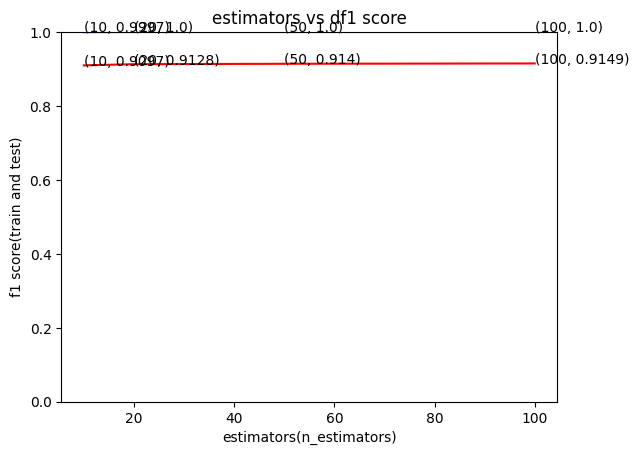

In [52]:
for i in range(0,len(cv_f1_score)):
  print('f1 value score n_estimators =' + str(estimators[i]) + ' is ' + str(cv_f1_score[i]))
plt.ylim(ymin=0)
plt.plot(estimators,cv_f1_score,c='r')
plt.plot(estimators,train_f1_score,c='b')
plt.xlabel('estimators(n_estimators)')
plt.ylabel('f1 score(train and test)')
plt.title('estimators vs df1 score')
for i,score in enumerate(cv_f1_score):
  plt.annotate((estimators[i],np.round(score,4)),(estimators[i],np.round(cv_f1_score[i],4)))
for i,score1 in enumerate(train_f1_score):
  plt.annotate((estimators[i],np.round(score1,4)),(estimators[i],np.round(train_f1_score[i],4)))

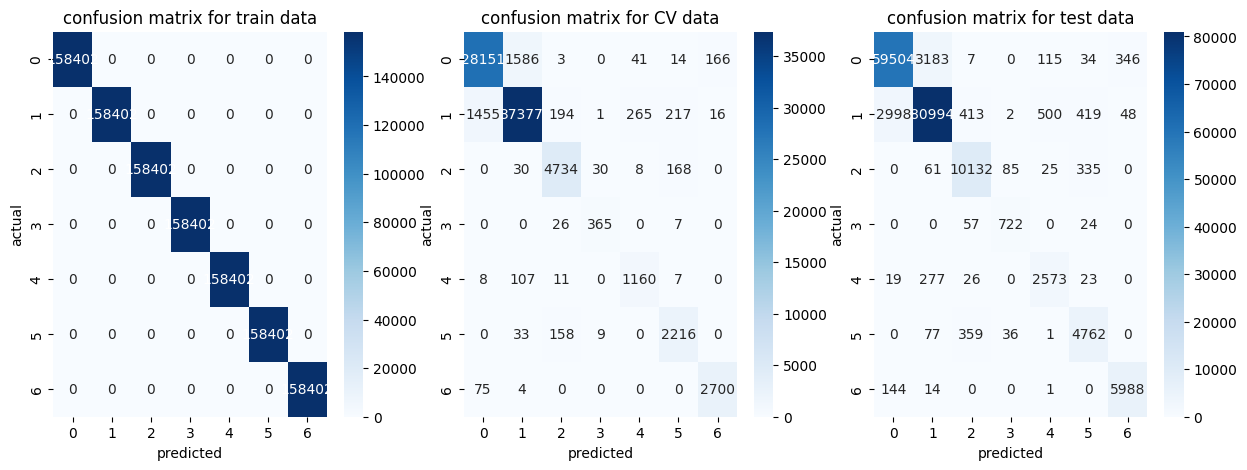

In [53]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
sns.heatmap(ax = ax[0],data = train_mat,annot=True,fmt='g',cmap="Blues")
ax[0].set_xlabel('predicted')
ax[0].set_ylabel('actual')
ax[0].title.set_text('confusion matrix for train data')
sns.heatmap(ax = ax[1],data = cv_mat,annot=True,fmt='g',cmap="Blues")
ax[1].set_xlabel('predicted')
ax[1].set_ylabel('actual')
ax[1].title.set_text('confusion matrix for CV data')
sns.heatmap(ax = ax[2],data = test_mat,annot=True,fmt='g',cmap="Blues")
ax[2].set_xlabel('predicted')
ax[2].set_ylabel('actual')
ax[2].title.set_text('confusion matrix for test data')

In [ ]:

model = RandomForestClassifier(n_estimators = 150,max_depth = 50,n_jobs = -1)
model.fit(x_train, y_train)
predict_train = model.predict(x_train)
print('f1 score on train data ' + str(f1_score(y_train,predict_train,average = 'macro')))
train_mat = confusion_matrix(y_train,predict_train)
predict_cv = model.predict(x_cv)
print('f1 score on cv data ' + str(f1_score(y_cv,predict_cv,average = 'macro')))
cv_mat = confusion_matrix(y_cv,predict_cv)
predict_test = model.predict(x_test)
print('f1 score on test data ' + str(f1_score(y_test,predict_test,average = 'macro')))
test_mat = confusion_matrix(y_test,predict_test)
fig,ax = plt.subplots(1,3,figsize = (15,5))
sns.heatmap(ax = ax[0],data = train_mat,annot=True,fmt='g',cmap="YlGnBu")
ax[0].set_xlabel('predicted')
ax[0].set_ylabel('actual')
ax[0].title.set_text('confusion matrix for train data')
sns.heatmap(ax = ax[1],data = cv_mat,annot=True,fmt='g')
ax[1].set_xlabel('predicted')
ax[1].set_ylabel('actual')
ax[1].title.set_text('confusion matrix for CV data')
sns.heatmap(ax = ax[2],data = test_mat,annot=True,fmt='g')
ax[2].set_xlabel('predicted')
ax[2].set_ylabel('actual')
ax[2].title.set_text('confusion matrix for test data')

In [195]:
best_rf_model = RandomForestClassifier(n_estimators=100,criterion='gini', max_depth=50,max_features = 'auto')

In [196]:
best_rf_model.fit(X_train_smote, Y_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=50, max_features='auto')

In [197]:
pred=best_rf_model.predict(x_test)

In [198]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     63324
           1       0.96      0.95      0.96     85372
           2       0.92      0.95      0.93     10647
           3       0.87      0.89      0.88       833
           4       0.80      0.90      0.85      2844
           5       0.85      0.91      0.88      5192
           6       0.94      0.97      0.95      6092

    accuracy                           0.95    174304
   macro avg       0.90      0.93      0.91    174304
weighted avg       0.95      0.95      0.95    174304



In [199]:
pred_cv=best_rf_model.predict(x_cv)

In [200]:
print(classification_report(y_cv, pred_cv))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     29650
           1       0.96      0.95      0.96     39723
           2       0.92      0.95      0.94      4989
           3       0.86      0.88      0.87       368
           4       0.81      0.89      0.85      1347
           5       0.84      0.91      0.88      2457
           6       0.93      0.97      0.95      2808

    accuracy                           0.95     81342
   macro avg       0.90      0.93      0.91     81342
weighted avg       0.95      0.95      0.95     81342

